### Import Libraries & Load Dataset

In [22]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GroupShuffleSplit

import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv(
    r"E:\A\OneDrive\Documents\3rd year\5th SEM Materials of SR.Mishra(3rd yr)\Machine Learning for Predictive Analytics\Project\1\Dataset\archive (1)\ecommerce_customer_data_custom_ratios.csv"
)

print("Original Shape:", df.shape)
df.head()

Original Shape: (250000, 13)


,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,37,0.0,Christine Hernandez,37,Male,0
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,37,0.0,Christine Hernandez,37,Male,0
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,37,0.0,Christine Hernandez,37,Male,0
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,37,0.0,Christine Hernandez,37,Male,0
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,49,0.0,James Grant,49,Female,1


### Data Preprocessing

In [23]:
# Check missing values
print("Missing values before cleaning:\n", df.isnull().sum())

# Remove missing values (essential columns)
df = df.dropna(subset=['Customer ID', 'Purchase Date', 'Product Category', 'Product Price', 'Quantity'])

# Fill numeric missing values with median
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Check duplicates
print("Number of duplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()

# Remove invalid transactions
df = df[(df["Quantity"] > 0) & (df["Product Price"] > 0)]

# Convert data types
df["Purchase Date"] = pd.to_datetime(df["Purchase Date"], errors="coerce")
df["Customer ID"] = df["Customer ID"].astype(int)

print("Missing values after cleaning:\n", df.isnull().sum())
print("Shape after preprocessing:", df.shape)


Missing values before cleaning:
 Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47596
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64
Number of duplicate rows: 0
Missing values after cleaning:
 Customer ID              0
Purchase Date            0
Product Category         0
Product Price            0
Quantity                 0
Total Purchase Amount    0
Payment Method           0
Customer Age             0
Returns                  0
Customer Name            0
Age                      0
Gender                   0
Churn                    0
dtype: int64
Shape after preprocessing: (250000, 13)


### Feature Engineering

In [24]:
# Transaction value
df["TotalPrice"] = df["Quantity"] * df["Product Price"]

# Extract date features
df["PurchaseMonth"] = df["Purchase Date"].dt.month
df["PurchaseDay"] = df["Purchase Date"].dt.day
df["PurchaseHour"] = df["Purchase Date"].dt.hour

# Encode categorical features
categorical_cols = ['Product Category', 'Payment Method', 'Gender']
for col in categorical_cols:
    if col in df.columns:
        df[col + "_Code"] = LabelEncoder().fit_transform(df[col])

# Define target variable
y = df['Churn']

# Define features (drop target & columns that can leak info)
X = df.drop(columns=[
    'Churn', 'TotalPrice', 'Quantity',
    'Customer ID', 'Customer Name', 'Purchase Date'
])

for col in categorical_cols:
    if col + "_Code" in X.columns:
        continue
    if col in X.columns:
        X[col + "_Code"] = LabelEncoder().fit_transform(X[col])
        X = X.drop(columns=[col])

# Fill numeric missing values
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

### original DataFrame

In [25]:
print("Churn count in original data:")
print(df['Churn'].value_counts())


Churn count in original data:
Churn
0    200126
1     49874
Name: count, dtype: int64


### Data after SMOTE

In [26]:
import pandas as pd

print("Churn count after SMOTE:")
print(pd.Series(y_train_res).value_counts())


Churn count after SMOTE:
Churn
0    160270
1    160270
Name: count, dtype: int64


### Train-Test Split & SMOTE 

In [27]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Target
y = df["Churn"]

# Features: drop columns that can leak info
X = df.drop(columns=[
    'Churn', 'TotalPrice', 'Quantity',
    'Customer ID', 'Customer Name', 'Purchase Date'
])

# Encode categorical columns
categorical_cols = ['Product Category', 'Payment Method', 'Gender']  # add more if needed
for col in categorical_cols:
    if col in X.columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# Fill numeric missing values
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# Grouped train/test split (to avoid customer-level leakage)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=df['Customer ID']))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Apply SMOTE on training data (after encoding)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Scale numeric columns
scaler = StandardScaler()
X_train_res[numeric_cols] = scaler.fit_transform(X_train_res[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Check shapes and class distribution
print("X_train_res shape:", X_train_res.shape)
print("X_test shape:", X_test.shape)
print("y_train_res shape:", y_train_res.shape)
print("y_test shape:", y_test.shape)

print("\nChurn count before SMOTE:\n", y_train.value_counts())
print("\nChurn count after SMOTE:\n", pd.Series(y_train_res).value_counts())

X_train_res shape: (320540, 14)
X_test shape: (50229, 14)
y_train_res shape: (320540,)
y_test shape: (50229,)

Churn count before SMOTE:
 Churn
0    160270
1     39501
Name: count, dtype: int64

Churn count after SMOTE:
 Churn
0    160270
1    160270
Name: count, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_21592\2227513409.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


### Define Features and Target

In [29]:
### Prevent Data Leakage & Apply SMOTE (Corrected)

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Target
y = df["Churn"]

# Features: drop columns that can leak target info
X = df.drop(columns=[
    'Churn', 'TotalPrice', 'Quantity',  # Removed 'Purchased' as it doesn't exist
    'Customer ID', 'Customer Name', 'Purchase Date'
])

# Encode categorical columns safely
categorical_cols = ['Product Category', 'Payment Method', 'Gender']  # add any object columns
for col in categorical_cols:
    if col in X.columns:
        le = LabelEncoder()
        X[col + "_Code"] = le.fit_transform(X[col])
        X = X.drop(columns=[col])

# Fill missing numeric values only
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# Grouped train/test split to prevent customer-level leakage
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=df['Customer ID']))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Scale numeric features
scaler = StandardScaler()
X_train_res[numeric_cols] = scaler.fit_transform(X_train_res[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Check shapes
print("Before SMOTE - y_train value counts:\n", y_train.value_counts())
print("\nAfter SMOTE - y_train_res value counts:\n", pd.Series(y_train_res).value_counts())
print("\nX_train_res shape:", X_train_res.shape)
print("X_test shape:", X_test.shape)
print("y_train_res shape:", y_train_res.shape)
print("y_test shape:", y_test.shape)


Before SMOTE - y_train value counts:
 Churn
0    160270
1     39501
Name: count, dtype: int64

After SMOTE - y_train_res value counts:
 Churn
0    160270
1    160270
Name: count, dtype: int64

X_train_res shape: (320540, 11)
X_test shape: (50229, 11)
y_train_res shape: (320540,)
y_test shape: (50229,)


C:\Users\user\AppData\Local\Temp\ipykernel_21592\3717917728.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


### Feature Scaling

In [30]:
from sklearn.preprocessing import StandardScaler

# Scale numeric features after SMOTE
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

# Check shapes and a sample
print("X_train_res shape:", X_train_res.shape)
print("X_test shape:", X_test.shape)
print("y_train_res shape:", y_train_res.shape)
print("y_test shape:", y_test.shape)

print("\nFirst 5 rows of scaled X_train_res:\n", X_train_res[:5])


X_train_res shape: (320540, 11)
X_test shape: (50229, 11)
y_train_res shape: (320540,)
y_test shape: (50229,)

First 5 rows of scaled X_train_res:
 [[-1.71170336 -1.37698035 -0.44114917 -0.88126707 -0.44114917  0.94660444
  -0.8932655  -0.3478774   0.81009709 -0.34473405  1.20881108]
 [ 1.5117161   0.00901161 -0.44114917 -0.88126707 -0.44114917 -0.96000156
  -1.25083556  0.10904088  1.77889381  1.54456039  1.20881108]
 [ 0.23931368  0.32586921 -0.44114917 -0.88126707 -0.44114917 -0.32446623
   0.8945848   1.02287744  1.77889381  1.54456039  1.20881108]
 [-0.41102533  0.54288546 -0.44114917 -0.88126707 -0.44114917  1.58213978
  -0.41650542  0.26134697 -0.15869963  1.54456039  1.20881108]
 [ 1.37740696  0.50336493  0.34889076 -0.88126707  0.34889076  1.58213978
   1.37134488  0.87057134  1.77889381 -0.34473405 -0.82725912]]


### Define Model and Hyperparameters

In [31]:
model = RandomForestClassifier()

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, None]
}


### Train Random Forest with Hyperparameter Tuning

In [32]:
model = RandomForestClassifier()

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, None]
}

grid = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_res, y_train_res)  # Train on balanced data

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)

print("\n===== Random Forest Results =====")
print("Best Parameters:", grid.best_params_)
print("Accuracy:", acc)
print(classification_report(y_test, y_pred))


===== Random Forest Results =====
Best Parameters: {'max_depth': None, 'n_estimators': 200}
Accuracy: 0.7125166736347528
              precision    recall  f1-score   support

           0       0.79      0.86      0.83     39856
           1       0.21      0.14      0.17     10373

    accuracy                           0.71     50229
   macro avg       0.50      0.50      0.50     50229
weighted avg       0.67      0.71      0.69     50229



### Aggregate Past Purchases by Customer

In [34]:
top_products = (
    df.groupby(['Customer ID', 'Product Category'])['Quantity']
    .sum()
    .reset_index()
    .sort_values(['Customer ID', 'Quantity'], ascending=[True, False])
)

top_products.head(10)
print(df['Customer ID'].unique()[:10])


[46251 13593 28805 28961 12163 28248  6761 17018 11462 43388]


### Data Analysis & Visualization

    Customer ID Product Category  Quantity
0             1            Books         5
1             2            Books         5
2             2      Electronics         3
3             3            Books        10
4             3         Clothing        10
5             3      Electronics         2
6             3             Home         1
7             4         Clothing         9
10            5             Home        13
8             5         Clothing        11


C:\Users\user\AppData\Local\Temp\ipykernel_21592\1180056791.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_products.values, y=top10_products.index, palette="viridis")


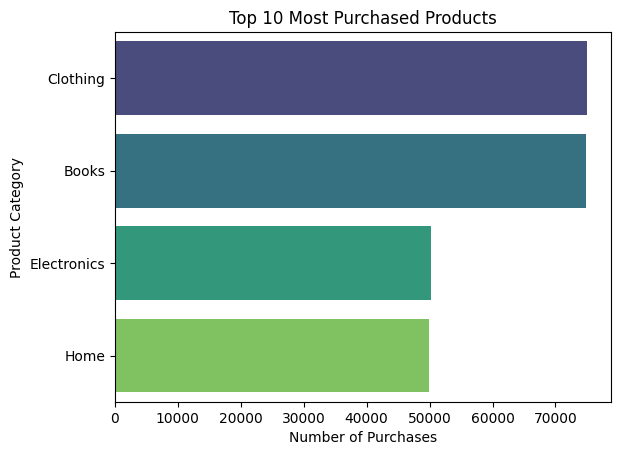

C:\Users\user\AppData\Local\Temp\ipykernel_21592\1180056791.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_customers.values, y=top_customers.index, palette="magma")


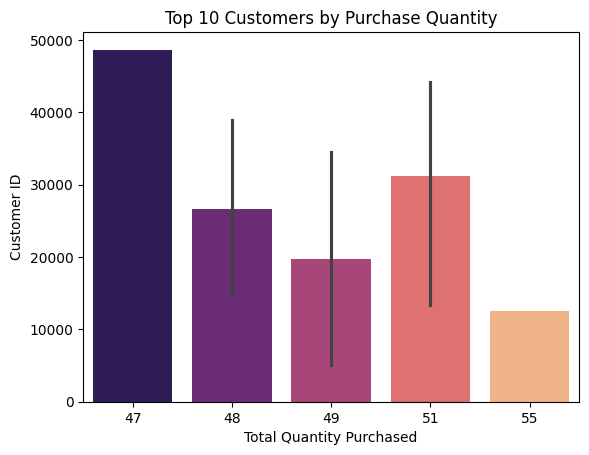

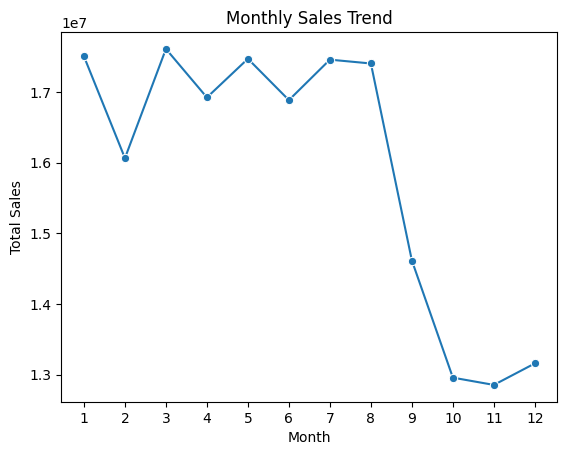

In [35]:
# Top products
top_products = (
    df.groupby(['Customer ID', 'Product Category'])['Quantity']
    .sum()
    .reset_index()
    .sort_values(['Customer ID', 'Quantity'], ascending=[True, False])
)
print(top_products.head(10))

# Top 10 Products
top10_products = df['Product Category'].value_counts().head(10)
sns.barplot(x=top10_products.values, y=top10_products.index, palette="viridis")
plt.title("Top 10 Most Purchased Products")
plt.xlabel("Number of Purchases")
plt.ylabel("Product Category")
plt.show()

# Top 10 Customers
top_customers = df.groupby('Customer ID')['Quantity'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_customers.values, y=top_customers.index, palette="magma")
plt.title("Top 10 Customers by Purchase Quantity")
plt.xlabel("Total Quantity Purchased")
plt.ylabel("Customer ID")
plt.show()

# Monthly Sales Trend
monthly_sales = df.groupby('PurchaseMonth')['TotalPrice'].sum()
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(monthly_sales.index)
plt.show()